# Preprocessing

## Loading Data

### Importing

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras import regularizers
from IPython.display import display, HTML
import warnings

### Loading

In [2]:
path = os.getcwd()
path

'/Users/vishalbalaji/GitHub-repos/AI---1/Project'

In [3]:
# df_19 = pd.read_csv('players_19.csv')
# df_20 = pd.read_csv('players_20.csv')

df_19 = pd.read_csv(path + '/fifadataset/players_19.csv')
df_20 = pd.read_csv(path + '/fifadataset/players_20.csv')
df_19.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,...,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,...,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


In [4]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df

In [5]:
pretty_print(tbl_report(df_19, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'], card = 11))

Table Shape (17770, 104)


,dtype,nulls,num_uniques,value_counts
sofifa_id,int64,0,17770,HC
player_url,object,0,17770,HC
short_name,object,0,16811,HC
long_name,object,0,17710,HC
age,int64,0,29,HC
dob,object,0,6093,HC
height_cm,int64,0,51,HC
weight_kg,int64,0,57,HC
nationality,object,0,160,HC
club,object,0,679,HC


## Column Transformations

### OneHot Encoding

**As we can see from the above, a lot of the columns are of type object**

This is because some of them are in the format "85+2". We need to transform those variables here.

In [6]:
def add_subtract(x):
    if '-' in x:
        return(int(x.split('-')[0]) - int(x.split('-')[1]))
    if '+' in x:
        return(int(x.split('+')[0]) + int(x.split('+')[1]))
    else:
        return(int(x))

In [7]:
change_cols = df_19.columns[list(df_19.columns).index('attacking_crossing'):]
for i in change_cols:
    df_19[i] = df_19[i].fillna('0').apply(lambda x: add_subtract(x))

**We thought of using the player traits column, and this function one hot encodes the comma separated values in that column**

In [8]:
def oh_normal(column):
    oh = OneHotEncoder()
    return(pd.DataFrame(oh.fit_transform(column).toarray(),columns=oh.categories_[0]).astype(int))
    
    


def comma(column):
    column = column.fillna('0')
    column = column.apply(lambda x: x.replace(' ',''))
    column = column.apply(lambda x: x.split(','))

    flat_list = [item for sublist in column for item in sublist]
    uniques = np.unique(np.asarray(flat_list))

    overall = []
    for i in column:
        zeroes = np.zeros(len(uniques)).astype(int)
        long = len(i)

        for j in range(long):
            zeroes[np.where(uniques == i[j])] = 1
        overall.append(zeroes)

    frame = pd.DataFrame(overall,columns=uniques)

    return(frame)

In [9]:
oh_cols = ['nationality','club','team_position']
oh_comma = ['player_traits'] 

In [10]:
#One hot encoding for columns with comma separated values
traits_df = comma(df_19[oh_comma[0]]).drop('0',axis = 1)
df_19 = df_19.drop(oh_comma[0],axis=1).join(traits_df)

### Getting Predictor and Response Variables

#### Predictor Variables

**These columns will be our main predictors**

In some parts of the notebook, we have used a combination of these attributes along with player traits. But as we will see below, it does not really improve performance, so we have not used it everywhere

In [11]:
attribute_cols = df_19.columns[list(df_19.columns).index('pace'):list(df_19.columns).index('ls')]
# player_pos = df_19.columns[[list(df_19.columns).index('player_positions')]]
# attribute_cols = attribute_cols.append(player_pos)
attribute_cols

Index(['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning',

**We are initializing traits for 2020 also here so we can use only the traits that are common between the 2**

We have made sure that this does not leak any information from the test to the training set

In [12]:
traits_cols = df_19.columns[list(df_19.columns).index('1-on-1Rush'):]

In [13]:
traits_df_20 = comma(df_20[oh_comma[0]]).drop('0',axis = 1)
traits_cols_20 = traits_df_20.columns

In [14]:
common_cols = set(traits_cols).intersection(set(traits_cols_20))

In [15]:
df_attributes = df_19[attribute_cols].fillna(0).astype(int)
df_total = df_attributes.join(df_19[common_cols].fillna(0).astype(int))

**Final training dataframe with only player attributes**

In [16]:
minmax_attributes = MinMaxScaler()
attributes_train = pd.DataFrame(minmax_attributes.fit_transform(df_attributes),columns=df_attributes.columns)

**Final training dataframe with player attributes and player traits**

In [17]:
minmax_total = MinMaxScaler()
total_train = pd.DataFrame(minmax_total.fit_transform(df_total),columns=df_total.columns)

#### Response variables

**The response variable is a list of comma separated values**

Many players have more than 1 position. We tried doing some [multiclass logistic regression](https://stackoverflow.com/questions/36523558/multi-class-logistic-regression-in-scikit-learn) but could not really get it to work.

We saw some notebooks online where they had taken the first value in the player position column. We decided it would be a good idea to take a random value from the positions to add some stochasticity to the model

In [18]:
player_pos_df = df_19['player_positions']

**Random selection of variables from each row**

In [19]:
random_pos = []
for i in player_pos_df:
    dummy = i.split(',')
    random_pos.append(dummy[np.random.randint(0,len(dummy))].strip())

In [20]:
positions = pd.Series(random_pos).unique()
positions.sort()

In [21]:
positions

array(['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW', 'LWB',
       'RB', 'RM', 'RW', 'RWB', 'ST'], dtype=object)

**Bucketing in GK, Defence, Midfield, Offence**

We have used 2 strategies for getting a response variable:

    1. Bucketing the postions into 4 categories: Goalkeeper, Defender, Midfielder and Forward
    2. Taking all the categories individually. This generally gives rise to 15 or 16 different positions across the players

In [22]:
mapping_dict = {
'GK':0 ,
'LWB':1 ,
'LB':1 ,
'LCB':1 ,
'CB':1 ,
'RCB':1 ,
'RB':1 ,
'RWB':1 ,
'LDM':2 ,
'CDM':2 ,
'RDM':2 ,
'LM':2 ,
'LCM':2 ,
'CM':2 ,
'RCM':2 ,
'RM':2 ,
'LAM':2 ,
'CAM':2 ,
'RAM':2 ,
'LW':3 ,
'LF':3 ,
'CF':3 ,
'RF':3 ,
'RW':3 ,
'LS':3 ,
'ST':3 ,
'RS':3 ,
}

In [23]:
mapped_pos_buckets = []
for i in random_pos:
    mapped_pos_buckets.append(mapping_dict[i])

**Bucketing in full**

In [24]:
mapping_dict_full = {}
for i in range(len(positions)):
    mapping_dict_full[positions[i]] = i

In [25]:
mapping_dict_full

{'CAM': 0,
 'CB': 1,
 'CDM': 2,
 'CF': 3,
 'CM': 4,
 'GK': 5,
 'LB': 6,
 'LM': 7,
 'LW': 8,
 'LWB': 9,
 'RB': 10,
 'RM': 11,
 'RW': 12,
 'RWB': 13,
 'ST': 14}

In [26]:
mapped_pos_full = []
for i in random_pos:
    mapped_pos_full.append(mapping_dict_full[i])

## Preprocessing for the Test set

**We are doing basic preprocessing of the Test Set to make it resemble the Training Set. We also take values only from the required clubs**

In [27]:
df_20 = pd.read_csv(path + '/fifadataset/players_20.csv')

In [28]:
test_clubs = ['FC Barcelona','FC Bayern München','Real Madrid' ,'Paris Saint-Germain','Juventus','Atlético Madrid','Manchester City','Liverpool','Manchester United']

test_attributes = pd.DataFrame(minmax_attributes.transform(df_20[attribute_cols].fillna(0)),columns=attribute_cols).join(df_20['club'])
test_attributes = test_attributes[test_attributes['club'].isin(test_clubs)].drop('club',axis=1)

# traits_df_20 = comma(df_20[oh_comma[0]]).drop('0',axis = 1)
# df_20 = df_20.drop(oh_comma[0],axis=1).join(traits_df_20)

# test_total = pd.DataFrame(minmax_total.transform(df_20[sum_cols].fillna(0)),columns=sum_cols).join(df_20['club'])
# test_total = test_total[test_total['club'].isin(test_clubs)].drop('club',axis=1)

In [29]:
test_total = df_20[attribute_cols].join(traits_df_20[common_cols]).fillna(0)
test_total = pd.DataFrame(minmax_total.transform(test_total),columns=test_total.columns).join(df_20['club'])
test_total = test_total[test_total['club'].isin(test_clubs)].drop('club',axis=1)

**Similar to the training set, we also take 2 test sets bucketed into the 4 categories or taken as is**

In [30]:
df_test = df_20[df_20['club'].isin(test_clubs)]

player_pos_df = df_test['player_positions']

random_pos = []
for i in player_pos_df:
    dummy = i.split(',')
    random_pos.append(dummy[np.random.randint(0,len(dummy))].strip())
    
positions = pd.Series(random_pos).unique()
positions.sort()

mapped_pos_buckets_test = []
for i in random_pos:
    mapped_pos_buckets_test.append(mapping_dict[i])
    
mapping_dict_full_test = {}
for i in range(len(positions)):
    mapping_dict_full_test[positions[i]] = i

mapped_pos_full_test = []
for i in random_pos:
    mapped_pos_full_test.append(mapping_dict_full[i])

# Modelling

## Model Selection

### Logistic Regression

**Testing with only attributes and 4 buckets for response**

In [31]:
warnings.filterwarnings("ignore")

# X_train = df_attributes
# y_train = mapped_pos_buckets


logreg = LogisticRegression(random_state=42)
cross_score = cross_validate(logreg,attributes_train,mapped_pos_buckets,scoring='accuracy',cv = 10,return_train_score=True)

average_test_score = np.mean(cross_score['test_score'])
print(f'Average test accuracy on cross validation across 10 folds is {average_test_score}')

Average test accuracy on cross validation across 10 folds is 0.8549240292628026


Cross validation gives an accuracy of **85%** on a basic logistic regression, which is very good. But let us try this without the buckets

**Testing with only attributes and 15 buckets for response**

In [32]:
warnings.filterwarnings("ignore")

# X_train = df_attributes
# y_train = mapped_pos_buckets


logreg = LogisticRegression(random_state=42)
cross_score = cross_validate(logreg,attributes_train,mapped_pos_full,scoring='accuracy',cv = 10,return_train_score=True)

average_test_score = np.mean(cross_score['test_score'])
print(f'Average test accuracy on cross validation across 10 folds is {average_test_score}')

Average test accuracy on cross validation across 10 folds is 0.5930782217220034


As we can see, having a lot of buckets impacts the accuracy of a model greatly, decreasing from **85% to 59%**. But in our opinion, 60% accuracy is good with 15 buckets. As we will see below, even this model performs badly only with midfielders and wingers a lot, who often play ambiguous roles in games and hence have atypical attributes and traits

**Let us find out if adding all the player traits we used is impacting performance in any meaningful way**

**Testing with attributes and traits and 4 buckets for response**

In [33]:
warnings.filterwarnings("ignore")

# X_train = df_attributes
# y_train = mapped_pos_buckets


logreg = LogisticRegression(random_state=42)
cross_score = cross_validate(logreg,total_train,mapped_pos_buckets,scoring='accuracy',cv = 10,return_train_score=True)

average_test_score = np.mean(cross_score['test_score'])
print(f'Average test accuracy on cross validation across 10 folds is {average_test_score}')

Average test accuracy on cross validation across 10 folds is 0.8546426561620709


Performance actually seems to have decreased ever so slightly. But there is some randomness here, generally the additional traits columns only add ~ +- 0.5% accuracy

**Testing with attributes and traits and 15 buckets for response**

In [34]:
warnings.filterwarnings("ignore")

# X_train = df_attributes
# y_train = mapped_pos_buckets


logreg = LogisticRegression(random_state=42)
cross_score = cross_validate(logreg,total_train,mapped_pos_full,scoring='accuracy',cv = 10,return_train_score=True)

average_test_score = np.mean(cross_score['test_score'])
print(f'Average test accuracy on cross validation across 10 folds is {average_test_score}')

Average test accuracy on cross validation across 10 folds is 0.5910523353967361


The same is the case with 15 buckets. The model is pretty much unaffected by the additional columns

**Let us try to use only attributes now (since adding traits does not really improve performance much) and try some different solvers and regularization on logistic regression and see how it improves our performace**

In [35]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
c = [0.001,0.01,0.01,0.1,1,10,100]
params = {'solver':solver_list,'C':c}
logreg = LogisticRegression(random_state=42)
clf = GridSearchCV(logreg, params, cv = 10)
clf.fit(df_attributes,mapped_pos_buckets)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']})

In [36]:
clf.best_estimator_

LogisticRegression(C=1, random_state=42)

In [37]:
clf.best_score_

0.855374226223973

We can see here that our base model itself performs almost on par with the best model, so we can consider that accuracy itself -- of 85.5%

### KNN

**Let us try cross validating on KNN and compare how it performs with Logistic Regression**

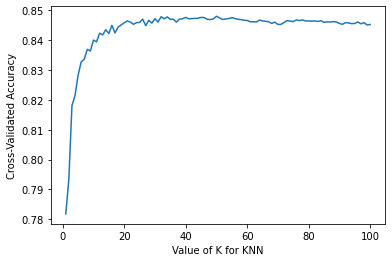

In [38]:
k_range = range(1, 101)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, attributes_train, mapped_pos_buckets, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [39]:
print(f'The maximum accuracy is {max(k_scores):.4f}')
print(f'The k-value for maximum accuracy is {k_range[k_scores.index(max(k_scores))]}')

The maximum accuracy is 0.8480
The k-value for maximum accuracy is 50


As we can see the scores are slightly lesser than that for Logistic Regression

Let us now try with the total train dataset (with attributes and player traits) but the same degree

In [41]:
knn = KNeighborsClassifier(n_neighbors=50)
tot_score = cross_val_score(knn, total_train, mapped_pos_buckets, cv=10, scoring='accuracy')
mean_score = np.mean(tot_score)
print(f'The mean accuracy with attributes and traits is {mean_score:.4f}')

The mean accuracy with attributes and traits is 0.8293


### Multi layer Perceptron

**First we train on only attributes with 4 prediction buckets**

In [31]:
df_attributes.shape

(17770, 46)

**We experimented with a few different layouts for layers before deciding on this one**

In [32]:
from tensorflow.keras import regularizers
# Input Parameters
n_input = 46 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_outputs = 4

Inp = Input(shape=(n_input,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_outputs, activation='softmax', name = "Output_Layer")(x)

model_4 = Model(Inp, output)


learning_rate = 0.01
training_epochs = 100
batch_size = 100
sgd = optimizers.SGD(lr=learning_rate)

model_4.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model_4.fit(attributes_train, np.array(mapped_pos_buckets),
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_split=0.2)

2021-10-29 23:07:28.877602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-29 23:07:29.068601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
143/143 - 1s - loss: 1.2397 - accuracy: 0.3781 - val_loss: 1.1883 - val_accuracy: 0.4246
Epoch 2/100
143/143 - 0s - loss: 1.0350 - accuracy: 0.5532 - val_loss: 0.9776 - val_accuracy: 0.7251
Epoch 3/100
143/143 - 0s - loss: 0.7956 - accuracy: 0.6872 - val_loss: 0.6791 - val_accuracy: 0.7819
Epoch 4/100
143/143 - 0s - loss: 0.5862 - accuracy: 0.7467 - val_loss: 0.5088 - val_accuracy: 0.8405
Epoch 5/100
143/143 - 0s - loss: 0.5022 - accuracy: 0.7750 - val_loss: 0.4411 - val_accuracy: 0.8433
Epoch 6/100
143/143 - 0s - loss: 0.4718 - accuracy: 0.7839 - val_loss: 0.4233 - val_accuracy: 0.8306
Epoch 7/100
143/143 - 0s - loss: 0.4562 - accuracy: 0.7929 - val_loss: 0.4137 - val_accuracy: 0.8286
Epoch 8/100
143/143 - 0s - loss: 0.4442 - accuracy: 0.8007 - val_loss: 0.4143 - val_accuracy: 0.8270
Epoch 9/100
143/143 - 0s - loss: 0.4399 - accuracy: 0.8018 - val_loss: 0.3798 - val_accuracy: 0.8621
Epoch 10/100
143/143 - 0s - loss: 0.4285 - accuracy: 0.8089 - val_loss: 0.4090 - val_accura

Epoch 82/100
143/143 - 0s - loss: 0.3601 - accuracy: 0.8510 - val_loss: 0.3324 - val_accuracy: 0.8768
Epoch 83/100
143/143 - 0s - loss: 0.3611 - accuracy: 0.8497 - val_loss: 0.3328 - val_accuracy: 0.8723
Epoch 84/100
143/143 - 0s - loss: 0.3601 - accuracy: 0.8498 - val_loss: 0.3649 - val_accuracy: 0.8573
Epoch 85/100
143/143 - 0s - loss: 0.3590 - accuracy: 0.8518 - val_loss: 0.3528 - val_accuracy: 0.8731
Epoch 86/100
143/143 - 0s - loss: 0.3602 - accuracy: 0.8518 - val_loss: 0.4200 - val_accuracy: 0.8202
Epoch 87/100
143/143 - 0s - loss: 0.3618 - accuracy: 0.8501 - val_loss: 0.3280 - val_accuracy: 0.8748
Epoch 88/100
143/143 - 0s - loss: 0.3588 - accuracy: 0.8500 - val_loss: 0.3310 - val_accuracy: 0.8728
Epoch 89/100
143/143 - 0s - loss: 0.3569 - accuracy: 0.8512 - val_loss: 0.3460 - val_accuracy: 0.8610
Epoch 90/100
143/143 - 0s - loss: 0.3585 - accuracy: 0.8505 - val_loss: 0.3244 - val_accuracy: 0.8799
Epoch 91/100
143/143 - 0s - loss: 0.3581 - accuracy: 0.8514 - val_loss: 0.3261 - v

556/556 [==============================] - 0s 611us/step - loss: 0.3656 - accuracy: 0.8486
The training set accuracy for the model is 0.8486212491989136


Text(0.5, 0.98, 'MLP Training')

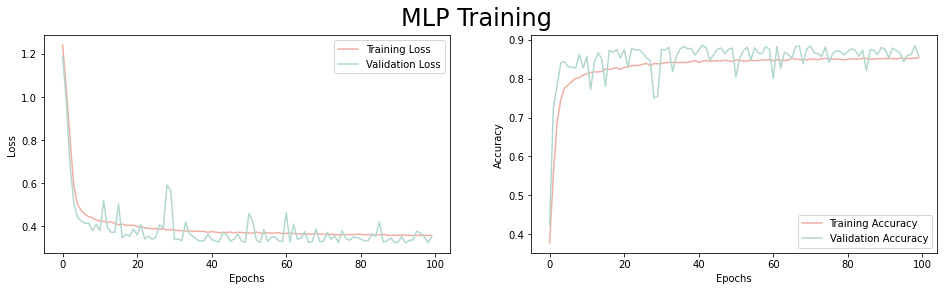

In [33]:
train_accuracy = model_4.evaluate(attributes_train,np.array(mapped_pos_buckets))[1]
print(f'The training set accuracy for the model is {train_accuracy}')

# Here we plot the training and validation loss and accuracy

fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy');
fig.suptitle('MLP Training', fontsize = 24)

**Let us also train the model with only attributes and 15 buckets**

In [34]:
# Input Parameters
n_input = 46 # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_outputs = 15

Inp = Input(shape=(n_input,))
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu',name = "Hidden_Layer_4")(x)
output = Dense(num_outputs, activation='softmax', name = "Output_Layer")(x)

model_15 = Model(Inp, output)


learning_rate = 0.01
training_epochs = 100
batch_size = 100
sgd = optimizers.SGD(lr=learning_rate)

model_15.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model_15.fit(attributes_train, np.array(mapped_pos_full),
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_split=0.2)

Epoch 1/100
143/143 - 1s - loss: 2.5821 - accuracy: 0.2093 - val_loss: 2.4446 - val_accuracy: 0.3205
Epoch 2/100
143/143 - 0s - loss: 2.3279 - accuracy: 0.3851 - val_loss: 2.1820 - val_accuracy: 0.4215
Epoch 3/100
143/143 - 0s - loss: 2.0688 - accuracy: 0.3940 - val_loss: 1.8320 - val_accuracy: 0.4496
Epoch 4/100
143/143 - 0s - loss: 1.7961 - accuracy: 0.4280 - val_loss: 1.5895 - val_accuracy: 0.5270
Epoch 5/100
143/143 - 0s - loss: 1.6180 - accuracy: 0.4625 - val_loss: 1.5065 - val_accuracy: 0.5070
Epoch 6/100
143/143 - 0s - loss: 1.5302 - accuracy: 0.4715 - val_loss: 1.3796 - val_accuracy: 0.5492
Epoch 7/100
143/143 - 0s - loss: 1.4795 - accuracy: 0.4762 - val_loss: 1.3577 - val_accuracy: 0.5580
Epoch 8/100
143/143 - 0s - loss: 1.4451 - accuracy: 0.4896 - val_loss: 1.3180 - val_accuracy: 0.5703
Epoch 9/100
143/143 - 0s - loss: 1.4155 - accuracy: 0.4991 - val_loss: 1.2811 - val_accuracy: 0.5760
Epoch 10/100
143/143 - 0s - loss: 1.3895 - accuracy: 0.5079 - val_loss: 1.2581 - val_accura

Epoch 82/100
143/143 - 0s - loss: 1.1377 - accuracy: 0.5772 - val_loss: 1.1611 - val_accuracy: 0.5979
Epoch 83/100
143/143 - 0s - loss: 1.1364 - accuracy: 0.5765 - val_loss: 1.0466 - val_accuracy: 0.6339
Epoch 84/100
143/143 - 0s - loss: 1.1374 - accuracy: 0.5815 - val_loss: 1.0692 - val_accuracy: 0.6263
Epoch 85/100
143/143 - 0s - loss: 1.1330 - accuracy: 0.5812 - val_loss: 1.2245 - val_accuracy: 0.5729
Epoch 86/100
143/143 - 0s - loss: 1.1366 - accuracy: 0.5808 - val_loss: 1.0808 - val_accuracy: 0.6120
Epoch 87/100
143/143 - 0s - loss: 1.1346 - accuracy: 0.5791 - val_loss: 1.0418 - val_accuracy: 0.6362
Epoch 88/100
143/143 - 0s - loss: 1.1357 - accuracy: 0.5830 - val_loss: 1.0575 - val_accuracy: 0.6339
Epoch 89/100
143/143 - 0s - loss: 1.1330 - accuracy: 0.5836 - val_loss: 1.0659 - val_accuracy: 0.6244
Epoch 90/100
143/143 - 0s - loss: 1.1327 - accuracy: 0.5823 - val_loss: 1.0450 - val_accuracy: 0.6370
Epoch 91/100
143/143 - 0s - loss: 1.1322 - accuracy: 0.5831 - val_loss: 1.0529 - v

556/556 [==============================] - 0s 658us/step - loss: 1.1408 - accuracy: 0.5837
The training set accuracy for the model is 0.5836803317070007


Text(0.5, 0.98, 'MLP Training')

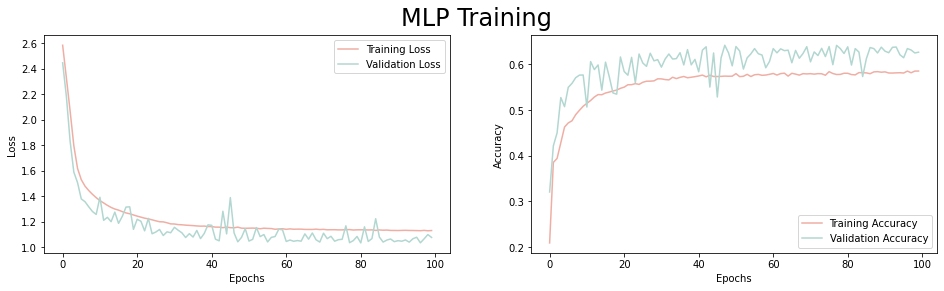

In [35]:
train_accuracy = model_15.evaluate(attributes_train,np.array(mapped_pos_full))[1]
print(f'The training set accuracy for the model is {train_accuracy}')

# Here we plot the training and validation loss and accuracy

fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy');
fig.suptitle('MLP Training', fontsize = 24)

**Note: In MLP model we tried with L2 regularization with lambda=0.01, it didnt improve accuracy much, however with lambda=0.1, the accuracy dropped for both type of models(with 4 and 15 classes). With  regularization and Early stopping(patience value = 10 and 50) accuracy value didn't improve respectively = 0.54(for 15 class model) and without these 0.59, and with(4 class model) = 0.81,wheras with only L2 regularization = 0.81, without any callback and regularization, accuracy is 0.85**

## Testing

**As we saw above, we are choosing MLP as the best model. Let us test our data with MLP**

In [36]:
prediction_4 = model_4.predict(test_attributes)

final_prediction_4 = []
for i in prediction_4:
    final_prediction_4.append(np.argmax(i))
    
accuracy_score(final_prediction_4,mapped_pos_buckets_test)

0.8466898954703833

**We are getting 85% accuracy on the test set too, which is very good**

In [37]:
prediction_15 = model_15.predict(test_attributes)

final_prediction_15 = []
for i in prediction_15:
    final_prediction_15.append(np.argmax(i))
    
accuracy_score(final_prediction_15,mapped_pos_full_test)

0.5435540069686411

**The difference between training score and testing score is a lot in this case**

Text(1149.5909090909088, 0.5, 'Predicted')

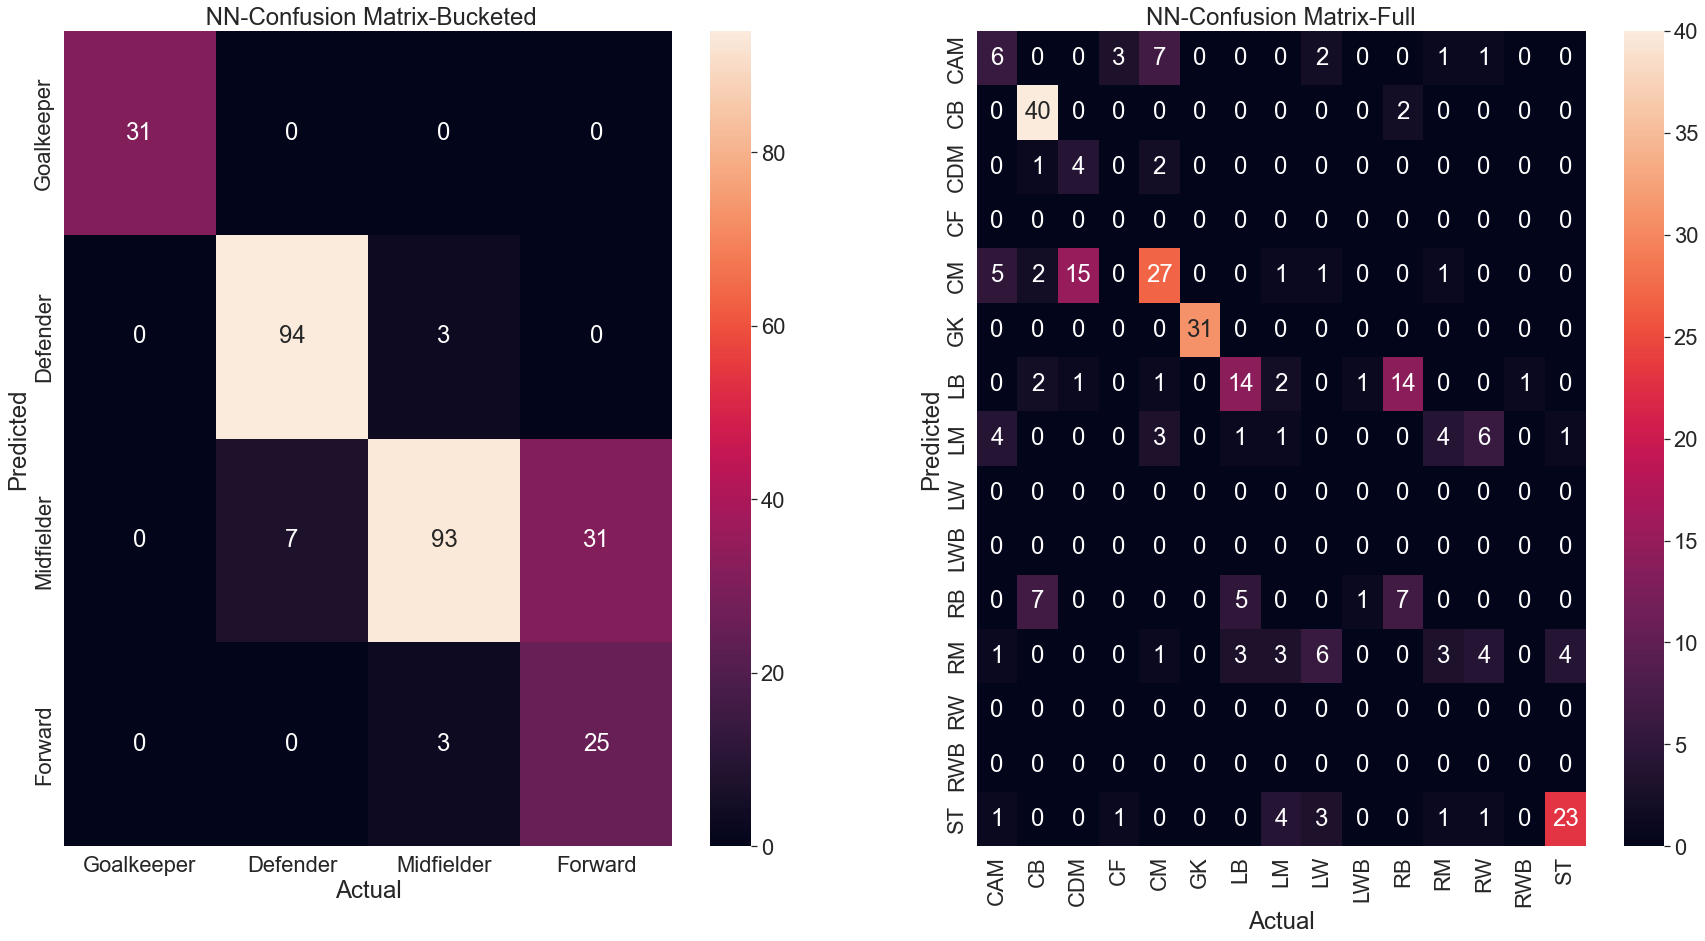

In [48]:
# Plot Confusion Matrix-Neural Networks for both  prediction models -test cases- 4 Responses and 15 responses
# Convert Confusion matrix to dataframes
cm_nn_bucketed_test = confusion_matrix(final_prediction_4,mapped_pos_buckets_test)
df_cm = pd.DataFrame(cm_nn_bucketed_test, index = [i for i in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']],
                  columns = [i for i in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']])
cm_nn_full_test = confusion_matrix(final_prediction_15,mapped_pos_full_test)
df_cm_full = pd.DataFrame(cm_nn_full_test, index = [i for i in mapping_dict_full.keys()],
                  columns = [i for i in mapping_dict_full.keys()])
fig, axes = plt.subplots(1,2,figsize=(30,15))
sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True,ax = axes[0])

axes[0].set_title(' NN-Confusion Matrix-Bucketed')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
sns.heatmap(df_cm_full, annot=True, ax = axes[1])

axes[1].set_title('NN-Confusion Matrix-Full')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

**Let us try fitting the model with our second best model too, which is the Logistic Regression**

In [50]:
warnings.filterwarnings("ignore")
logreg_buckets = LogisticRegression(random_state=42)
logreg_buckets.fit(attributes_train,mapped_pos_buckets)

logreg_pred_buckets = logreg_buckets.predict(test_attributes)
accuracy_score(logreg_pred_buckets,mapped_pos_buckets_test)

0.8536585365853658

**We are getting a test accuracy of 85% similar to training accuracy, and this is incidentally better than the NN too**

In [41]:
warnings.filterwarnings("ignore")
logreg_full = LogisticRegression(random_state=42)
logreg_full.fit(attributes_train,mapped_pos_full)

logreg_pred_full = logreg_full.predict(test_attributes)
accuracy_score(logreg_pred_full,mapped_pos_full_test)

0.578397212543554

**Our test accuracy here is similar to that from our cross validation**

Text(1149.5909090909088, 0.5, 'Predicted')

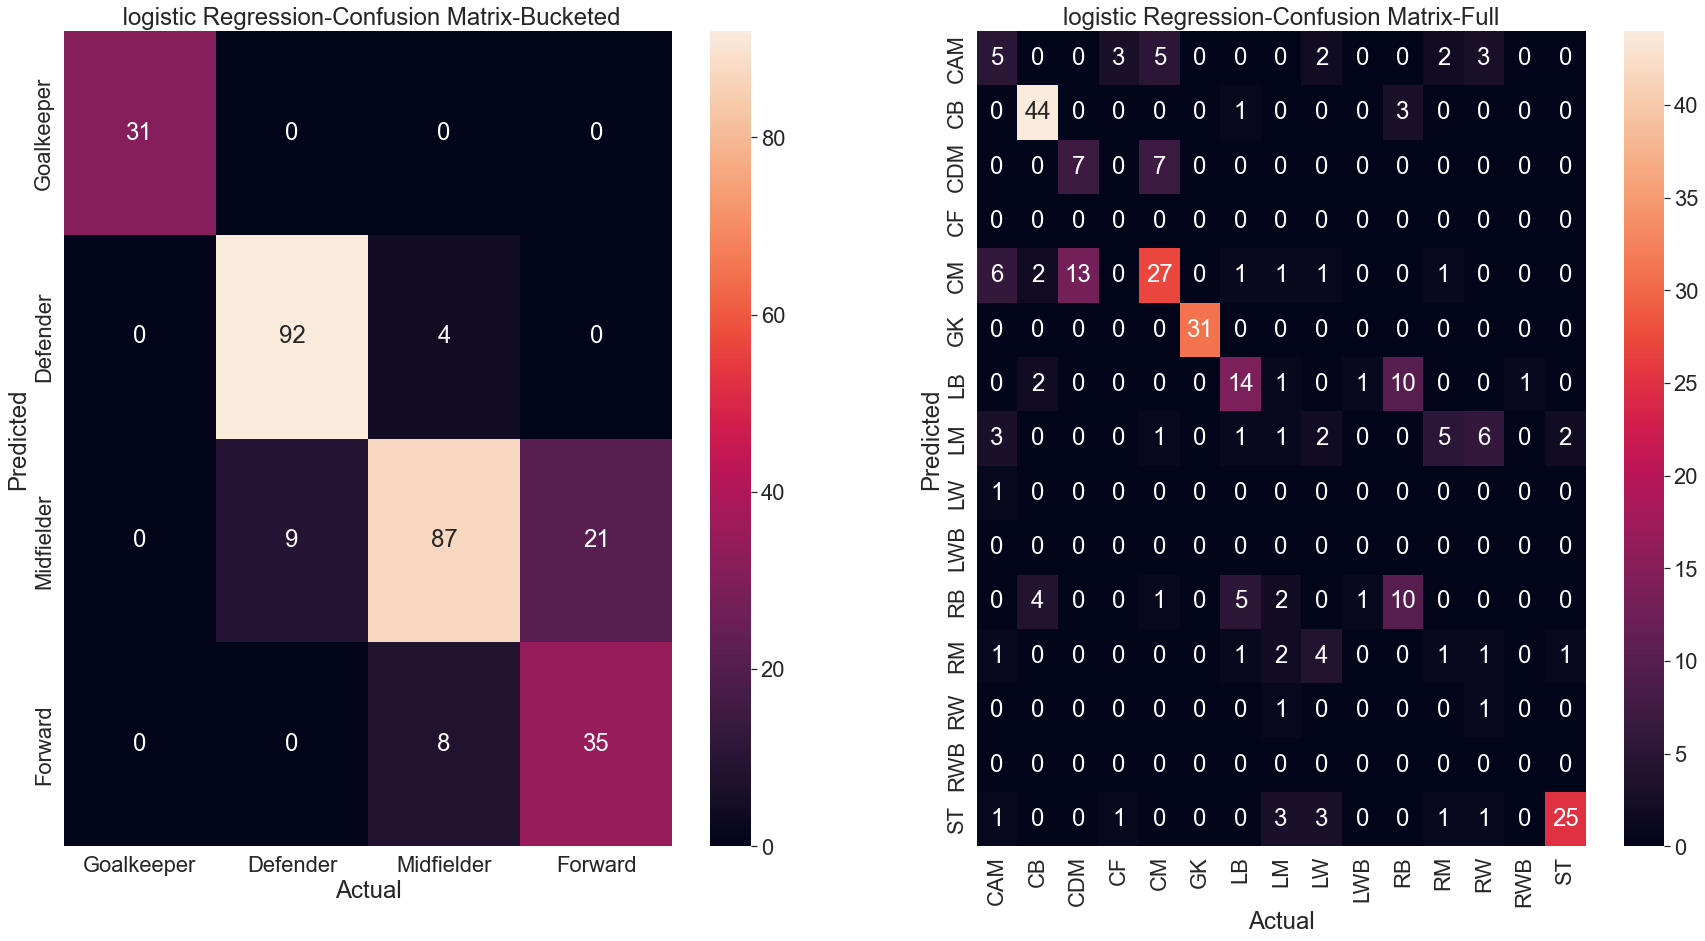

In [47]:
# Plot Confusion Matrix for both  prediction models -test cases- 4 Responses and 15 responses
# Convert Confusion matrix to dataframes
cm_nn_bucketed_test = confusion_matrix(logreg_pred_buckets,mapped_pos_buckets_test)
df_cm = pd.DataFrame(cm_nn_bucketed_test, index = [i for i in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']],
                  columns = [i for i in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']])
cm_nn_full_test = confusion_matrix(logreg_pred_full,mapped_pos_full_test)
df_cm_full = pd.DataFrame(cm_nn_full_test, index = [i for i in mapping_dict_full.keys()],
                  columns = [i for i in mapping_dict_full.keys()])
fig, axes = plt.subplots(1,2,figsize=(30,15))
sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True,ax = axes[0])

axes[0].set_title(' logistic Regression-Confusion Matrix-Bucketed')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
sns.heatmap(df_cm_full, annot=True, ax = axes[1])

axes[1].set_title('logistic Regression-Confusion Matrix-Full')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

## Trying Random Forests

**Let us see if we can improve performance. From our previous experience in ML-2, we have found that Random Forests perform very well at this kind of task. So let us try fitting a RF model on only attributes data with 4 buckets to see if we can improve performance**

In [43]:
rf = RandomForestClassifier(warm_start=True, oob_score=True, n_jobs=-1, random_state=66)
param_grid_rf = { "n_estimators": range(500,1000, 100), "max_depth": range(5,9)}

clf = GridSearchCV(rf, param_grid_rf, cv = 10)
clf.fit(attributes_train,mapped_pos_buckets)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=66,
                                              warm_start=True),
             param_grid={'max_depth': range(5, 9),
                         'n_estimators': range(500, 1000, 100)})

In [44]:
clf.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=900, n_jobs=-1, oob_score=True,
                       random_state=66, warm_start=True)

In [45]:
clf.best_score_

0.8380416432189082

In [46]:
rf = clf.best_estimator_
rf.fit(attributes_train,mapped_pos_buckets)

rf_pred = rf.predict(test_attributes)
accuracy_score(rf_pred,mapped_pos_buckets_test)

0.8257839721254355

**Random Forests are still performing lower than Logistic Regression and NN in this case**